# **Deep Learning Models**
   Goal: Capture complex temporal patterns
## Models
 - LSTM
 - GRU
 - Temporal CNN
 - Seq2Seq
 - Transformer (advanced)

## Techniques
 - Sliding windows
 - Multivariate sequences
 - Early stopping
 - GPU acceleration (if available)

  Output: Best DL model


## DL Foundations & Data Preparation
 - Load feature-engineered dataset
 - Select DL-safe features
 - Normalize numeric features (fit on train only)
 - Encode categoricals (embeddings-ready)
 - Create sliding windows
 - Define sequence tensors
### concepts
 - Multivariate time series
 - Sliding window formulation
 - Sequence-to-one forecasting

### Output
 - X_train_seq, y_train_seq
 - X_valid_seq, y_valid_seq
 - scaler.pkl
 - feature_index.json## Load Feature-Engineered Dataset

In [1]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

fatal: destination path 'Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform' already exists and is not an empty directory.


In [2]:
# Import Libraries
# Imports
import os
import gc
import time
import json
import joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler

In [3]:
# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Set Project Root
os.chdir('/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform')
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [5]:
# Load Feature Engineered Data
df = pd.read_parquet("data/features/train_features.parquet")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)

print(df.shape)
df.head()

(3054348, 62)


,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,is_comp_workday,is_pre_holiday,is_post_holiday,family_freq,store_freq,city_freq,state_freq,sales_log,family_te,store_te
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0.030303,0.018519,0.333333,0.351852,0.000000,1.612195,3.148359
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,0,0,1,0.030303,0.018519,0.333333,0.351852,1.098612,1.612195,3.148359
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,0,0.030303,0.018519,0.333333,0.351852,1.386294,1.612195,3.148359
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,0,0.030303,0.018519,0.333333,0.351852,1.386294,1.612195,3.148359
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,1,0,0,0.030303,0.018519,0.333333,0.351852,1.791759,1.612195,3.148359


In [6]:
# Train Validatoin Split
SPLIT_DATE = "2017-01-01"

train_df = df[df["date"] < SPLIT_DATE].copy()
valid_df = df[df["date"] >= SPLIT_DATE].copy()

print(train_df.shape, valid_df.shape)


(2642706, 62) (411642, 62)


In [7]:
# Drop NaN values in Lag/Roll Features
# identify Lag/Roll Columns
lag_cols = [col for col in train_df.columns if "lag" in col or "roll" in col]

# Drop NaN
initial_rows = len(train_df)

train_df = train_df.dropna(subset=lag_cols)

print(f"Rows dropped: {initial_rows - len(train_df)}")
print(f"Remaining Rows: {len(train_df)}")
print(f"Loose Percentage: {100 * (initial_rows - len(train_df)) / initial_rows:.2f}")


Rows dropped: 49896
Remaining Rows: 2592810
Loose Percentage: 1.89


In [8]:
# Feature Selection
TARGET = "sales_log"

NUMERIC_FEATURES = [
    "onpromotion",
    "cluster",
    "dcoilwtico",
    "is_holiday",
    "is_workday",
    "earthquake",
    "is_payday",
    "week_of_year",
    "is_weekend",
    "is_month_end",

    "sales_lag_1",
    "sales_lag_7",
    "sales_lag_14",
    "sales_lag_28",

    "promo_lag_1",
    "promo_lag_7",

    "oil_lag_7",
    "oil_lag_14",
    "oil_lag_28",

    "sales_roll_mean_7",
    "sales_roll_mean_14",
    "sales_roll_mean_28",

    "sales_roll_std_7",
    "sales_roll_std_14",
    "sales_roll_std_28",

    "promo_roll_sum_7",
    "promo_roll_sum_14",
    "promo_roll_sum_28",

    "promo_flag",
    "promo_freq_7",
    "promo_freq_14",
    "promo_freq_28",

    "is_national_holiday",
    "is_regional_holiday",
    "is_local_holiday",
    "is_bridge",
    "is_comp_workday",
    "is_pre_holiday",
    "is_post_holiday",

    "family_freq",
    "store_freq",
    "city_freq",
    "state_freq",
]


CATEGORICAL_FEATURES = [
    "store_nbr",
    "family",
    "city",
    "state",
    "store_type",
    "holiday_type",
    "locale",
]

DL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

In [9]:
# Encode Categoricals (Integer IDs for Embeddings)
# Build Category
category_maps = {}

for col in CATEGORICAL_FEATURES:
  category_maps[col] = {
      v: i + 1 for i, v in enumerate(train_df[col].astype(str).unique())
    }


In [10]:
# Apply Encoding
def encode_categories(df, maps):
  df = df.copy()
  for col, mp in maps.items():
    df[col] = df[col].astype(str).map(mp).fillna(0).astype("int32")
  return df

train_df = encode_categories(train_df, category_maps)
valid_df = encode_categories(valid_df, category_maps)


In [11]:
# Normalize Numeric Features
scaler = StandardScaler()

train_df[NUMERIC_FEATURES] = scaler.fit_transform(train_df[NUMERIC_FEATURES])
valid_df[NUMERIC_FEATURES] = scaler.transform(valid_df[NUMERIC_FEATURES])


In [12]:
# Save scaler
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

In [13]:
# Memory Optimization (reduce memory usage)
def reduce_mem(df):
  for c in df.columns:
    if df[c].dtype == "float64":
      df[c] = df[c].astype("float32")
    elif df[c].dtype == "int64":
      df[c] = df[c].astype("int32")
  return df

train_df = reduce_mem(train_df)
valid_df = reduce_mem(valid_df)
gc.collect()


0

## Sliding Window Generator (Reusable Engine)

All DL models will reuse this logic.

### Build window generator:
 - window_size = 28
 - horizon = 1
 - Ensure time continuity per store-family
 - Batch-safe generator (tf / torch compatible)

### Output
 -  Sliding window function
 -  Memory-efficient batching
 -  Tested on small subset

In [14]:
# Sliding Window Function
def sliding_window_generator(
    df,
    window_size,
    horizon,
    feature_cols,
    target_col,
    batch_size=256,
):
    X_batch, y_batch = [], []

    for _, gdf in df.groupby(["store_nbr", "family"]):
        gdf = gdf.sort_values("date")

        X = gdf[feature_cols].values.astype("float32")
        y = gdf[target_col].values.astype("float32")

        if len(gdf) < window_size + horizon:
            continue

        for i in range(len(gdf) - window_size - horizon + 1):
            X_batch.append(X[i:i+window_size])
            y_batch.append(y[i+window_size+horizon-1])

            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.array(y_batch)
                X_batch, y_batch = [], []

    if X_batch:
        yield np.array(X_batch), np.array(y_batch)



In [15]:
## tf.data Dataset Wrapper
WINDOW_SIZE = 28
HORIZON = 1
BATCH_SIZE = 256

def make_dataset(df, shuffle=False):
  ds = tf.data.Dataset.from_generator(
    lambda: sliding_window_generator(
      df, WINDOW_SIZE, HORIZON, DL_FEATURES, TARGET, BATCH_SIZE
    ),
    output_signature=(
      tf.TensorSpec(shape=(None, WINDOW_SIZE, len(DL_FEATURES)), dtype=tf.float32),
      tf.TensorSpec(shape=(None,), dtype=tf.float32),
    ),
  )
  if shuffle:
      ds = ds.shuffle(1024)
  return ds.prefetch(tf.data.AUTOTUNE)

# Train and Validation datasets
train_ds = make_dataset(train_df, shuffle=True)
valid_ds = make_dataset(valid_df)


In [16]:
# Save Feature Map
feature_map = {
  "numeric_features": NUMERIC_FEATURES,
  "categorical_features": CATEGORICAL_FEATURES,
  "dl_features_order": DL_FEATURES,
  "category_maps": category_maps,
  "window_size": WINDOW_SIZE,
}

with open("models/dl_feature_map.json", "w") as f:
  json.dump(feature_map, f, indent=4)


In [17]:
# RMSLE Functoin
def rmsle_log(y_true, y_pred):
  y_true = np.expm1(y_true)
  y_pred = np.expm1(y_pred)
  y_pred = np.maximum(y_pred, 0)
  return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred))**2))



## Model 1: LSTM (Baseline DL)
 - Handles long dependencies
 - Strong baseline
 - Easy to interpret
### What we do
 - Build LSTM architecture
 - Sequence → Dense output
 - Early stopping
 - GPU detection

### Output
 - LSTM RMSLE
 - Training curves
 - Saved model

In [18]:
STEPS_PER_EPOCH = 2000
VAL_STEPS = 500

In [26]:
# Built LSMT Model - Basseline Architecture
lstm_model = Sequential([
  LSTM(64, input_shape=(WINDOW_SIZE, len(DL_FEATURES))),
  Dropout(0.2),
  Dense(1)
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss="mse"
)

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,505 (115.25 KB)

 Trainable params: 29,505 (115.25 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Training Setup

callbacks = [
  EarlyStopping(patience=5, restore_best_weights=True),
  ModelCheckpoint("models/lstm_best.keras", save_best_only=True)
]


In [27]:
# Train_model
history = lstm_model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=30,
  steps_per_epoch=STEPS_PER_EPOCH,
  validation_steps=VAL_STEPS,
  callbacks=callbacks,
  verbose=1
)


Epoch 1/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 3.2221 - val_loss: 0.7904
Epoch 2/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 1.4856 - val_loss: 0.7782
Epoch 3/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 1.2253 - val_loss: 0.9578
Epoch 4/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 1.2765 - val_loss: 0.9269
Epoch 5/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 1.1861 - val_loss: 0.9292
Epoch 6/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 1.0630 - val_loss: 0.5052
Epoch 7/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.9995 - val_loss: 0.4624
Epoch 8/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.9297 - val_loss: 0.7256
Epoch 9/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 1.0637 - val_loss: 0.7248
Epoch 10/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 1.0287 - val_loss: 0.7184
Epoch 11/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - loss: 0.9747 - val_loss: 0.5845
Epoch 12/

In [30]:
# Predict and Evaluate
X_val, y_val = next(sliding_window_generator(
  valid_df, WINDOW_SIZE, HORIZON, DL_FEATURES, TARGET, batch_size=2048
))

y_pred = lstm_model.predict(X_val).reshape(-1)
print("LSTM RMSLE:", rmsle_log(y_val, y_pred))



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM RMSLE: 0.6661667


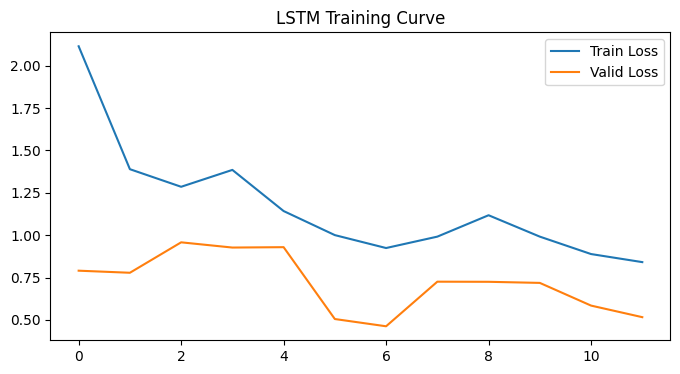

In [31]:
# Training Curves
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Valid Loss")
plt.legend()
plt.title("LSTM Training Curve")
plt.show()


In [32]:
# Save Model and Training History

lstm_model.save("models/lstm_model.keras")

# Save Training History
with open("models/lstm_history.json", "w") as f:
    json.dump(history.history, f)


## Model 2: GRU (Faster LSTM)
 - Faster than LSTM
 - Often same or better performance

### What we do
 - Replace LSTM with GRU
 - Same window & data
 - Compare speed vs accuracy

### Output

 - GRU RMSLE
 - Training speed comparison
 - Saved model

In [19]:
# Build GRU Model
num_features = len(DL_FEATURES)

gru_model = Sequential([
    GRU(
        units=64,
        return_sequences=False,
        input_shape=(WINDOW_SIZE, num_features)
    ),
    Dropout(0.2),
    Dense(1)
])


In [20]:
# Compile GRU Modle
gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss="mse"
)

gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Set Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint =ModelCheckpoint("models/gru_best.keras", save_best_only=True)

In [22]:
# Train GRU Model
start_time = time.time()

history_gru = gru_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=7,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

gru_training_time = time.time() - start_time
print(f"GRU Training Time: {gru_training_time:.2f} seconds")

Epoch 1/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 2.1058 - val_loss: 0.9050
Epoch 2/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - loss: 1.0309 - val_loss: 0.7086
Epoch 3/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 88s 8ms/step - loss: 0.8664 - val_loss: 0.6243
Epoch 4/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 0.8396 - val_loss: 0.6584
Epoch 5/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - loss: 0.7534 - val_loss: 0.5941
Epoch 6/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.7291 - val_loss: 0.6285
Epoch 7/7
9934/9934 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.7015 - val_loss: 0.5566
GRU Training Time: 673.05 seconds


In [23]:
# Evaluate GRU RMSLE
y_true_all = []
y_pred_all = []

for X_batch, y_batch in valid_ds:
    preds = gru_model.predict(X_batch, verbose=0).reshape(-1)
    y_true_all.append(y_batch.numpy())
    y_pred_all.append(preds)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

gru_rmsle = rmsle_log(y_true_all, y_pred_all)
print(f"GRU RMSLE: {gru_rmsle:.4f}")

GRU RMSLE: 0.7459


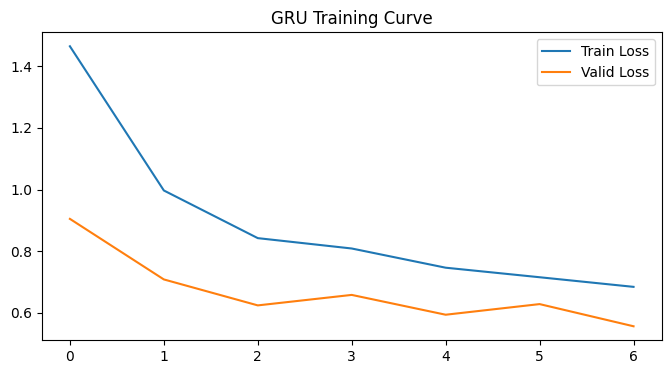

In [24]:
# GRU Training Curves
plt.figure(figsize=(8, 4))
plt.plot(history_gru.history["loss"], label="Train Loss")
plt.plot(history_gru.history["val_loss"], label="Valid Loss")
plt.legend()
plt.title("GRU Training Curve")
plt.show()

In [25]:
# Save Model
gru_model.save("models/gru_model.keras")

# Save Training History
with open("models/gru_history.json", "w") as f:
    json.dump(history_gru.history, f)